# IMPORTS

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
!pip install git+https://github.com/openai/CLIP.git
import clip
from torchvision import transforms
from PIL import Image
import os
from glob import glob
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split, Subset
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
from sklearn.linear_model import LogisticRegression
import random
from collections import defaultdict

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-p1ui2lht
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-p1ui2lht
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.8 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=24a97bea45a01b0762394b3ce13a165cbe2029b68b851113c26fa1fcda591ab7
  Stored in directory: /tmp/pip-ephem-wheel-cache-09r73e6o/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


# MODEL

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 80.7MiB/s]


# DATASET PREP

In [3]:
# Provide CLASSES explicitly (keeps label ordering identical across runs)
CLASSES = ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]
CLASS_TO_IDX = {c: i for i, c in enumerate(CLASSES)}

class PACSDataset(Dataset):
    def __init__(self, root_dir, domain, classes=CLASSES, transform=None):
        self.root_dir = os.path.join(root_dir, domain)
        self.transform = transform
        self.classes = classes
        self.class_to_idx = {c: CLASS_TO_IDX[c] for c in classes}
        self.samples = []
        exts = ["*.jpg", "*.jpeg", "*.png", "*.JPG"]

        for class_name in sorted(os.listdir(self.root_dir)):
            class_dir = os.path.join(self.root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            if class_name not in self.class_to_idx:
                # skip unexpected folders or .DS_Store etc.
                continue
            label_idx = self.class_to_idx[class_name]
            for ext in exts:
                for img_path in glob(os.path.join(class_dir, ext)):
                    self.samples.append((img_path, label_idx))

        print(f"Loaded {len(self.samples)} images from {domain}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label_idx = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label_idx


In [4]:
from google.colab import drive
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/DataSets/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: archive/pacs_data/pacs_data/sketch/giraffe/n02439033_15936-4.png  
  inflating: __MACOSX/archive/pacs_data/pacs_data/sketch/giraffe/._n02439033_15936-4.png  
  inflating: archive/pacs_data/pacs_data/sketch/giraffe/n02439033_10491-2.png  
  inflating: __MACOSX/archive/pacs_data/pacs_data/sketch/giraffe/._n02439033_10491-2.png  
  inflating: archive/pacs_data/pacs_data/sketch/giraffe/n02439033_10164-6.png  
  inflating: __MACOSX/archive/pacs_data/pacs_data/sketch/giraffe/._n02439033_10164-6.png  
  inflating: archive/pacs_data/pacs_data/sketch/giraffe/n02439033_10803-2.png  
  inflating: __MACOSX/archive/pacs_data/pacs_data/sketch/giraffe/._n02439033_10803-2.png  
  inflating: archive/pacs_data/pacs_data/sketch/giraffe/n02439033_14600-1.png  
  inflating: __MACOSX/archive/pacs_data/pacs_data/sketch/giraffe/._n02439033_14600-1.png  
  inflating: archive/pacs_data/pacs_data/sketch/giraffe/n02439033_14724-5.png  
  inflating: _

In [5]:
DATA_ROOT = "archive/pacs_data/pacs_data"
DOMAINS = ["art_painting", "cartoon", "photo", "sketch"]

datasets = {d: PACSDataset(DATA_ROOT, d, transform=preprocess) for d in DOMAINS}
loaders = {d: DataLoader(ds, batch_size=64, shuffle=False, num_workers=0) for d, ds in datasets.items()}

Loaded 2048 images from art_painting
Loaded 2344 images from cartoon
Loaded 1670 images from photo
Loaded 3929 images from sketch


Batch shape: torch.Size([64, 3, 224, 224])
Labels: tensor([0, 0, 0, 0, 0])


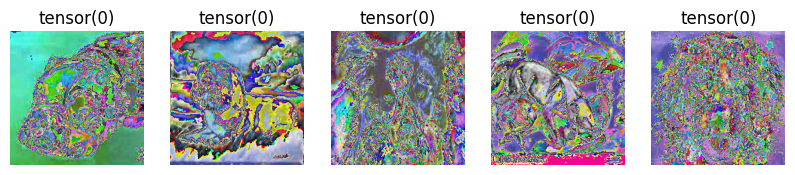

Batch shape: torch.Size([64, 3, 224, 224])
Labels: tensor([0, 0, 0, 0, 0])


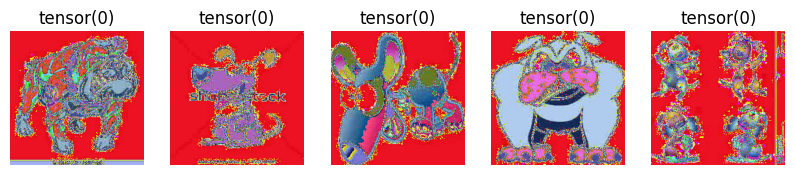

Batch shape: torch.Size([64, 3, 224, 224])
Labels: tensor([0, 0, 0, 0, 0])


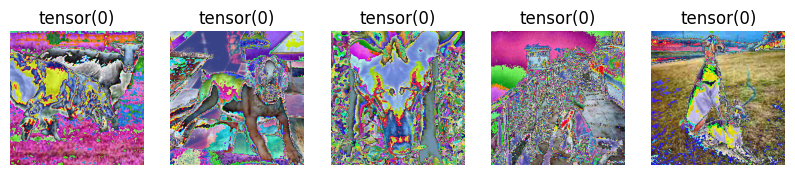

Batch shape: torch.Size([64, 3, 224, 224])
Labels: tensor([0, 0, 0, 0, 0])


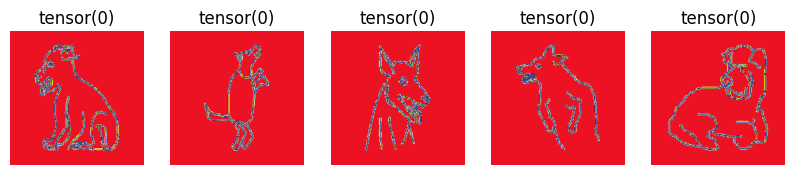

In [6]:
for d in loaders.keys():
    imgs, labels = next(iter(loaders[d]))

    print("Batch shape:", imgs.shape)
    print("Labels:", labels[:5])

    # Show a few images
    plt.figure(figsize=(10, 3))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(transforms.ToPILImage()(imgs[i]))
        plt.title(labels[i])
        plt.axis("off")
    plt.show()


# ZERO-SHOT CLASSIFICATION

In [7]:
PROMPT_TEMPLATES = {
    "photo": "a photo of a {}",
    "art_painting": "a painting of a {}",
    "cartoon": "a cartoon of a {}",
    "sketch": "a sketch of a {}",
}

In [8]:
@torch.no_grad()
def zeroshot_classifier(domain):
    prompts = [PROMPT_TEMPLATES[domain].format(c) for c in CLASSES]
    text_tokens = clip.tokenize(prompts).to(device)
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features


In [9]:
@torch.no_grad()
def evaluate_zero_shot(model, loader, domain):
    text_features = zeroshot_classifier(domain)   # same as before
    all_preds, all_labels = [], []

    for images, labels in tqdm(loader, desc=f"Evaluating {domain}"):
        images = images.to(device)
        if not torch.is_tensor(labels):
            labels = torch.tensor(labels, dtype=torch.long)
        labels = labels.to(device)

        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        logits = 100 * image_features @ text_features.T
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    return acc


In [ ]:
domain_accs = {}
for domain, loader in loaders.items():
    acc = evaluate_zero_shot(model, loader, domain)
    domain_accs[domain] = acc
    print(f"📊 Zero-Shot Accuracy on {domain}: {acc:.4f}")

print("\n=== Overall Zero-Shot Results ===")
for d, a in domain_accs.items():
    print(f"{d}: {a*100:.2f}%")

Evaluating art_painting: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]


📊 Zero-Shot Accuracy on art_painting: 0.9556


Evaluating cartoon: 100%|██████████| 37/37 [00:10<00:00,  3.52it/s]


📊 Zero-Shot Accuracy on cartoon: 0.9765


Evaluating photo: 100%|██████████| 27/27 [00:07<00:00,  3.58it/s]


📊 Zero-Shot Accuracy on photo: 0.9970


Evaluating sketch: 100%|██████████| 62/62 [00:16<00:00,  3.72it/s]

📊 Zero-Shot Accuracy on sketch: 0.8516

=== Overall Zero-Shot Results ===
art_painting: 95.56%
cartoon: 97.65%
photo: 99.70%
sketch: 85.16%


In [10]:
source_domains = ['art_painting', 'cartoon', 'photo']
source_dataset = ConcatDataset([datasets[d] for d in source_domains])
source_loader = DataLoader(source_dataset, batch_size=64, shuffle=True, num_workers=0)

target_domain = 'sketch'
target_loader = loaders[target_domain]

In [ ]:
class CLIPLinearHead(nn.Module):
    def __init__(self, clip_model, num_classes):
        super().__init__()
        self.clip_model = clip_model
        self.linear = nn.Linear(clip_model.visual.output_dim, num_classes)
        for p in self.clip_model.parameters():
            p.requires_grad = False  # freeze CLIP
    def forward(self, images):
        with torch.no_grad():
            feats = self.clip_model.encode_image(images)
            feats = feats / feats.norm(dim=-1, keepdim=True)
            feats = feats.float()
        logits = self.linear(feats)
        return logits

In [ ]:
num_classes = len(CLASSES)
linear_model = CLIPLinearHead(model, num_classes).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(linear_model.linear.parameters(), lr=1e-3)
epochs = 10

In [ ]:
for epoch in range(epochs):
    linear_model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in tqdm(source_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = linear_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    print(f"Epoch {epoch+1}: Loss={running_loss/len(source_loader):.4f}, Train Acc={(correct/total)*100:.2f}%")


Epoch 1/10: 100%|██████████| 95/95 [00:26<00:00,  3.54it/s]


Epoch 1: Loss=1.7523, Train Acc=81.44%


Epoch 2/10: 100%|██████████| 95/95 [00:27<00:00,  3.41it/s]


Epoch 2: Loss=1.4031, Train Acc=95.00%


Epoch 3/10: 100%|██████████| 95/95 [00:26<00:00,  3.56it/s]


Epoch 3: Loss=1.1243, Train Acc=96.24%


Epoch 4/10: 100%|██████████| 95/95 [00:29<00:00,  3.23it/s]


Epoch 4: Loss=0.9087, Train Acc=96.77%


Epoch 5/10: 100%|██████████| 95/95 [00:26<00:00,  3.65it/s]


Epoch 5: Loss=0.7447, Train Acc=97.13%


Epoch 6/10: 100%|██████████| 95/95 [00:26<00:00,  3.62it/s]


Epoch 6: Loss=0.6209, Train Acc=97.38%


Epoch 7/10: 100%|██████████| 95/95 [00:26<00:00,  3.63it/s]


Epoch 7: Loss=0.5267, Train Acc=97.49%


Epoch 8/10: 100%|██████████| 95/95 [00:26<00:00,  3.54it/s]


Epoch 8: Loss=0.4540, Train Acc=97.54%


Epoch 9/10: 100%|██████████| 95/95 [00:27<00:00,  3.49it/s]


Epoch 9: Loss=0.3972, Train Acc=97.72%


Epoch 10/10: 100%|██████████| 95/95 [00:26<00:00,  3.62it/s]

Epoch 10: Loss=0.3516, Train Acc=97.72%


In [ ]:
@torch.no_grad()
def evaluate_linear_head(linear_model, loader, device):
    linear_model.eval()
    correct, total = 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = linear_model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    acc = correct / total
    return acc

In [ ]:
domain_accs_linear = {}
for domain, loader in loaders.items():
    acc = evaluate_linear_head(linear_model, loader, device)
    domain_accs_linear[domain] = acc
    print(f"📊 Linear Head Accuracy on {domain}: {acc:.4f}")

print("\n=== Overall Linear Head Results ===")
for d, a in domain_accs_linear.items():
    print(f"{d}: {a*100:.2f}%")


📊 Linear Head Accuracy on art_painting: 0.9526
📊 Linear Head Accuracy on cartoon: 0.9846
📊 Linear Head Accuracy on photo: 0.9970
📊 Linear Head Accuracy on sketch: 0.8450

=== Overall Linear Head Results ===
art_painting: 95.26%
cartoon: 98.46%
photo: 99.70%
sketch: 84.50%


# Prompt-Learning using CoOp

In [11]:
def l2_normalize(x, dim=-1, eps=1e-12):
    return x / (x.norm(dim=dim, keepdim=True).clamp_min(eps))


class PromptLearner(nn.Module):
    """
    Split-context CoOp prompt for CLIP:
    - First part: learnable context (trainable)
    - Last part: frozen class label tokens (non-trainable)
    """

    def __init__(self, clip_model, classnames, ctx_len=8, init_from_text="a photo of a", device="cuda"):
        super().__init__()
        self.clip = clip_model
        self.device = device
        self.classnames = classnames
        self.ctx_len = ctx_len
        self.context_length = clip_model.context_length  # 77
        self.embed_dim = clip_model.token_embedding.weight.shape[1]
        dtype = clip_model.dtype

        # Tokenize the classnames
        class_token_ids = clip.tokenize(classnames).to(device)
        self.register_buffer("class_token_ids", class_token_ids)

        # Initialize learnable context
        with torch.no_grad():
            init_ids = clip.tokenize([init_from_text]).to(device)
            init_emb = clip_model.token_embedding(init_ids).squeeze(0)
            valid_mask = init_ids.squeeze(0) != 0
            avg = init_emb[valid_mask].mean(dim=0, keepdim=True)
            ctx_init = avg.repeat(ctx_len, 1)

        self.context_vectors = nn.Parameter(ctx_init.to(dtype))

        # Freeze CLIP backbone
        for p in self.clip.parameters():
            p.requires_grad = False

    def forward(self, selected_class_idx=None):
        device = self.device
        dtype = self.clip.dtype

        if selected_class_idx is None:
            class_ids = self.class_token_ids
        else:
            class_ids = self.class_token_ids[selected_class_idx]

        C_local, T_local = class_ids.shape

        with torch.no_grad():
            # Get embeddings for label tokens
            label_embs = self.clip.token_embedding(class_ids).to(dtype)
            pos_emb = self.clip.positional_embedding.to(dtype)

        # --- Construct new sequence: [CTX][LABEL][EOS] ---
        seq_emb = torch.zeros(
            C_local, self.ctx_len + T_local, self.embed_dim, device=device, dtype=dtype
        )
        seq_emb[:, :self.ctx_len, :] = self.context_vectors.unsqueeze(0).expand(C_local, -1, -1)
        seq_emb[:, self.ctx_len:, :] = label_embs

        # Pad/truncate to CLIP’s required length (77)
        if seq_emb.shape[1] > self.context_length:
            seq_emb = seq_emb[:, :self.context_length, :]
        elif seq_emb.shape[1] < self.context_length:
            pad_len = self.context_length - seq_emb.shape[1]
            pad = torch.zeros(C_local, pad_len, self.embed_dim, device=device, dtype=dtype)
            seq_emb = torch.cat([seq_emb, pad], dim=1)

        seq_emb = seq_emb + pos_emb.unsqueeze(0)

        # Transformer expects (seq_len, batch, dim)
        x = seq_emb.permute(1, 0, 2)
        x = self.clip.transformer(x)
        x = x.permute(1, 0, 2)

        # Get EOS token index (last non-padding token)
        eos_pos = (class_ids != 0).sum(dim=1) - 1
        eos_pos = eos_pos + self.ctx_len
        eos_pos = eos_pos.clamp(max=self.context_length - 1)

        gathered = x[torch.arange(C_local, device=device), eos_pos, :]
        text_feats = self.clip.ln_final(gathered) @ self.clip.text_projection
        text_feats = l2_normalize(text_feats, dim=-1)
        return text_feats.to(torch.float32)

    def get_text_features(self):
        text_features = self.forward()
        return text_features / text_features.norm(dim=-1, keepdim=True)


In [12]:
class PACSDataset(Dataset):
    def __init__(self, root_dir, domain, classes=CLASSES, transform=None, labeled=True):
        self.root_dir = os.path.join(root_dir, domain)
        self.transform = transform
        self.classes = classes
        self.labeled = labeled
        self.class_to_idx = {c: CLASS_TO_IDX[c] for c in classes}
        self.samples = []
        exts = ["*.jpg", "*.jpeg", "*.png", "*.JPG"]

        for class_name in sorted(os.listdir(self.root_dir)):
            class_dir = os.path.join(self.root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            if class_name not in self.class_to_idx:
                continue
            label_idx = self.class_to_idx[class_name]
            for ext in exts:
                for img_path in glob(os.path.join(class_dir, ext)):
                    self.samples.append((img_path, label_idx))

        print(f"Loaded {len(self.samples)} images from {domain}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label_idx = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        if self.labeled:
            return img, label_idx
        else:
            return img, -1  # placeholder label for unlabeled data


In [13]:
@torch.no_grad()
def image_features_from_clip(clip_model, images):
    """
    Safely get image features from clip. Convert them to float32 for downstream ops
    to avoid fp16/fp32 mismatch by default.
    """
    img_feats = clip_model.encode_image(images)  # might be float16
    img_feats = l2_normalize(img_feats, dim=-1)
    # convert to float32 to match text features dtype (text projection often float32)
    return img_feats.float()

def supervised_source_loss(clip_model, prompt_learner, images, labels, temperature):
    image_feats = image_features_from_clip(clip_model, images)
    text_feats = prompt_learner()
    image_feats = image_feats.to(torch.float32)
    text_feats = text_feats.to(torch.float32)

    image_feats = F.normalize(image_feats, dim=-1)
    text_feats = F.normalize(text_feats, dim=-1)

    logits = (image_feats @ text_feats.t()) / temperature
    loss = F.cross_entropy(logits, labels)
    return loss, logits


@torch.no_grad()
def predict_probs(clip_model, prompt_learner, images, temperature=1.0):
    # returns softmax probs and raw logits
    image_feats = image_features_from_clip(clip_model, images)
    text_feats = prompt_learner()
    logits = (image_feats @ text_feats.t()) / temperature
    probs = F.softmax(logits, dim=-1)
    return probs, logits

def unsupervised_target_loss(clip_model, prompt_learner, target_images,
                             pseudo_thresh=0.9, aug_fn=None, temperature=1.0, device="cuda"):
    """
    Unsupervised target loss combining:
     - pseudo-label cross-entropy on high-confidence predictions
     - entropy minimization on target (to encourage confident predictions)
     - optional consistency between original and augmented images (KL)
    """
    probs, logits = predict_probs(clip_model, prompt_learner, target_images, temperature)
    maxp, pseudo = probs.max(dim=1)
    device = target_images.device

    # pseudo-label loss (only on confident)
    mask = maxp > pseudo_thresh
    loss_pseudo = torch.tensor(0.0, device=device)
    if mask.any():
        loss_pseudo = F.cross_entropy(logits[mask], pseudo[mask])

    # entropy minimization (reduce average entropy)
    eps = 1e-8
    ent = - (probs * (probs + eps).log()).sum(dim=1).mean()
    loss_entropy = ent

    # consistency (augmented predictions should match)
    loss_cons = torch.tensor(0.0, device=device)
    if aug_fn is not None:
        imgs_aug = aug_fn(target_images)
        probs2, logits2 = predict_probs(clip_model, prompt_learner, imgs_aug, temperature)
        # KL divergence: probs (detach) vs probs2
        p = probs.detach()
        loss_cons = F.kl_div((probs2 + eps).log(), p, reduction="batchmean")

    # weighting hyperparams (tune)
    alpha = 1.0  # pseudo weight
    beta  = 0.1  # entropy weight
    gamma = 0.5  # consistency weight

    total = alpha * loss_pseudo + beta * loss_entropy + gamma * loss_cons
    stats = dict(pseudo=loss_pseudo.item(), entropy=loss_entropy.item(), consistency=loss_cons.item())
    return total, stats


In [14]:
def train_prompt_adaptation(clip_model, prompt_learner,
                                   source_loader, target_loader_unlabeled,
                                   optimizer, device="cuda",
                                   epochs=10, temperature=1.0, aug_fn=None,
                                   lambda_u=0.5):
    """
    Train prompt_learner parameters only.
    We iterate by zipping source and target loaders (if sizes differ it's okay)
    """
    clip_model.eval()
    prompt_learner.train()
    for epoch in range(epochs):
        running_sup, running_uns, cnt = 0.0, 0.0, 0
        # zip shortest; if you want full pass, you can use an iterator that cycles the smaller loader.
        it = zip(source_loader, target_loader_unlabeled)
        pbar = tqdm(it, total=min(len(source_loader), len(target_loader_unlabeled)))
        for (src_imgs, src_lbls), (tgt_imgs, _) in pbar:
            src_imgs = src_imgs.to(device)
            src_lbls = src_lbls.to(device)
            tgt_imgs = tgt_imgs.to(device)

            optimizer.zero_grad()

            sup_loss, _ = supervised_source_loss(clip_model, prompt_learner, src_imgs, src_lbls, temperature)
            uns_loss, uns_stats = unsupervised_target_loss(clip_model, prompt_learner, tgt_imgs,
                                                           pseudo_thresh=0.9, aug_fn=aug_fn,
                                                           temperature=temperature, device=device)
            loss = sup_loss + lambda_u * uns_loss

            loss.backward()
            optimizer.step()

            running_sup += sup_loss.item()
            running_uns += uns_loss.item()
            cnt += 1
            pbar.set_description(f"Epoch {epoch+1}/{epochs} sup={running_sup/cnt:.4f} uns={running_uns/cnt:.4f}")
    return prompt_learner


In [15]:
@torch.no_grad()
def evaluate_prompt(clip_model, prompt_learner, loader, device="cuda", temperature=1.0):
    clip_model.eval()
    prompt_learner.eval()
    correct = 0
    total = 0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        probs, logits = predict_probs(clip_model, prompt_learner, images, temperature)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return correct / total


In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)  # loads openai/clip model
# freeze clip model explicitly
model.eval()
for p in model.parameters():
    p.requires_grad = False
model.float()
CLASSES = ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]
CLASS_TO_IDX = {c: i for i, c in enumerate(CLASSES)}

DATA_ROOT = "archive/pacs_data/pacs_data"
SOURCE_DOMAINS = ["art_painting", "cartoon", "photo"]
TARGET_DOMAIN = "sketch"

print(f"Source domains: {SOURCE_DOMAINS}")
print(f"Target domain: {TARGET_DOMAIN}")

# Multiple source domains (labeled)
source_datasets = [
    PACSDataset(DATA_ROOT, d, transform=preprocess, labeled=True)
    for d in SOURCE_DOMAINS
]
source_dataset = ConcatDataset(source_datasets)

# Target domain (both labeled and unlabeled variants)
target_dataset_labeled = PACSDataset(DATA_ROOT, TARGET_DOMAIN, transform=preprocess, labeled=True)
target_dataset_unlabeled = PACSDataset(DATA_ROOT, TARGET_DOMAIN, transform=preprocess, labeled=False)

# Optionally split target into val/test for evaluation
val_size = int(0.2 * len(target_dataset_labeled))
test_size = len(target_dataset_labeled) - val_size
target_val, target_test = random_split(target_dataset_labeled, [val_size, test_size])


batch_size = 64
source_loader = DataLoader(source_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
target_loader_unlabeled = DataLoader(target_dataset_unlabeled, batch_size=batch_size, shuffle=True, num_workers=2)
target_val_loader = DataLoader(target_val, batch_size=batch_size, shuffle=False, num_workers=2)
target_test_loader = DataLoader(target_test, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"\n✅ Source dataset size: {len(source_dataset)}")
print(f"✅ Target unlabeled size: {len(target_dataset_unlabeled)}")
print(f"✅ Target val: {len(target_val)}, Target test: {len(target_test)}")

Source domains: ['art_painting', 'cartoon', 'photo']
Target domain: sketch
Loaded 2048 images from art_painting
Loaded 2344 images from cartoon
Loaded 1670 images from photo
Loaded 3929 images from sketch
Loaded 3929 images from sketch

✅ Source dataset size: 6062
✅ Target unlabeled size: 3929
✅ Target val: 785, Target test: 3144


In [17]:
import torch
import clip
from tqdm import tqdm

@torch.no_grad()
def evaluate_clip_zeroshot(model, source_loader, classnames, device="cuda"):
    """
    Evaluate zero-shot CLIP accuracy on PACS dataset.

    Args:
        model: CLIP model (from clip.load)
        source_loader: DataLoader yielding (images, labels)
        classnames: list of class names (e.g., ["dog", "cat", "horse", "giraffe"])
        device: torch device ("cuda" or "cpu")

    Returns:
        float: top-1 accuracy (in %)
    """
    model.eval()
    total = 0
    correct = 0

    # Construct zero-shot text embeddings
    templates = ["a photo of a {}", "a painting of a {}", "an image of a {}", "a sketch of a {}", "a cartoon of a {}"]
    text_prompts = [t.format(c) for c in classnames for t in templates]
    text_tokens = clip.tokenize(text_prompts).to(device)

    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        # average embeddings for each class
        num_templates = len(templates)
        text_features = text_features.view(len(classnames), num_templates, -1).mean(1)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    for images, labels in tqdm(source_loader, desc="Evaluating Zero-Shot CLIP"):
        images, labels = images.to(device), labels.to(device)

        # Encode images
        image_features = model.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # Compute similarity
        logits = image_features @ text_features.T  # cosine similarity
        preds = logits.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Zero-Shot CLIP Accuracy: {acc:.2f}%")
    return acc


In [18]:
classnames = ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]

# Assuming your source_loader is ready:
acc = evaluate_clip_zeroshot(model, source_loader, classnames, device)

Evaluating Zero-Shot CLIP: 100%|██████████| 95/95 [00:27<00:00,  3.46it/s]

Zero-Shot CLIP Accuracy: 97.86%


In [19]:
prompt = PromptLearner(model, CLASSES, ctx_len=4, device=device).to(device)

acc_prompt = evaluate_prompt(model, prompt, source_loader, device=device)
print(f"\n🎯 Source Accuracy before Prompt Adaptation (ctx_len = 4): {acc_prompt*100:.2f}%")

optimizer = torch.optim.Adam(prompt.parameters(), lr=1e-3)

prompt = train_prompt_adaptation(
    model, prompt,
    source_loader, target_loader_unlabeled,
    optimizer,
    device=device,
    epochs=10,
    temperature=1.0,
    lambda_u=0.5
)

# After training:
acc_prompt = evaluate_prompt(model, prompt, source_loader, device=device)
print(f"\n🎯 Source Accuracy after Prompt Adaptation (ctx_len = 4): {acc_prompt*100:.2f}%")


🎯 Source Accuracy before Prompt Adaptation (ctx_len = 4): 95.97%


Epoch 10/10 sup=1.7275 uns=0.1940: 100%|██████████| 62/62 [00:33<00:00,  1.85it/s]



🎯 Source Accuracy after Prompt Adaptation (ctx_len = 4): 96.39%


In [20]:
prompt_16 = PromptLearner(model, CLASSES, ctx_len=16, device=device).to(device)

acc_prompt = evaluate_prompt(model, prompt, source_loader, device=device)
print(f"\n🎯 Source Accuracy before Prompt Adaptation (ctx_len = 16): {acc_prompt*100:.2f}%")

optimizer = torch.optim.Adam(prompt.parameters(), lr=1e-3)

prompt_16 = train_prompt_adaptation(
    model, prompt,
    source_loader, target_loader_unlabeled,
    optimizer,
    device=device,
    epochs=10,
    temperature=1.0,
    lambda_u=0.5
)

# After training:
acc_prompt = evaluate_prompt(model, prompt, source_loader, device=device)
print(f"\n🎯 Source Accuracy after Prompt Adaptation (ctx_len = 16): {acc_prompt*100:.2f}%")


🎯 Source Accuracy before Prompt Adaptation (ctx_len = 16): 96.39%


Epoch 10/10 sup=1.7149 uns=0.1939: 100%|██████████| 62/62 [00:33<00:00,  1.85it/s]



🎯 Source Accuracy after Prompt Adaptation (ctx_len = 16): 95.66%


In [21]:
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
tokenizer = _Tokenizer()

with torch.no_grad():
    token_emb_table = model.token_embedding.weight  # (V, D)
    learned_ctx = prompt.context_vectors  # (ctx_len, D)

    # Cosine similarity between learned ctx and token embeddings
    sims = torch.matmul(
        F.normalize(learned_ctx, dim=-1),
        F.normalize(token_emb_table.T, dim=0)
    )  # (ctx_len, V)

    top_tokens = sims.topk(5, dim=-1).indices  # top 5 tokens for each context vector

# Decode top tokens to readable text
for i, token_ids in enumerate(top_tokens):
    words = [tokenizer.decode([t.item()]) for t in token_ids]
    print(f"Context vector {i}: nearest tokens -> {words}")


Context vector 0: nearest tokens -> ['indiefilm ', 'effic', 'न ', 'webcam ', 'a ']
Context vector 1: nearest tokens -> ['<|endoftext|>', '.." ', '" ', '".... ', '...." ']
Context vector 2: nearest tokens -> ['<|endoftext|>', 'a ', '" ', '# ', "' "]
Context vector 3: nearest tokens -> ['<|endoftext|>', '<|startoftext|>', '& ', '# ', 'ssnhq ']


In [22]:
@torch.no_grad()
def evaluate_zero_shot(model, dataloader, text_feats_or_domain, is_features=False):
    if not is_features:
        # build from template
        prompts = [PROMPT_TEMPLATES[text_feats_or_domain].format(c) for c in CLASSES]
        tokens = clip.tokenize(prompts).to(device)
        text_feats = model.encode_text(tokens)
        text_feats /= text_feats.norm(dim=-1, keepdim=True)
    else:
        # already given features
        text_feats = text_feats_or_domain

    all_preds, all_labels = [], []
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        image_feats = model.encode_image(images)
        image_feats /= image_feats.norm(dim=-1, keepdim=True)
        logits = 100.0 * image_feats @ text_feats.T
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    acc = (np.array(all_preds) == np.array(all_labels)).mean()
    return acc


In [23]:
def get_coop_text_features(model, prompt, classnames):
    """
    Builds text features for CoOp by inserting learned context embeddings
    into the token sequence while keeping CLIP's 77-token format intact.
    """
    clip_model = model
    device = prompt.device
    ctx = prompt.context_vectors  # (ctx_len, dim)
    ctx_len = ctx.size(0)
    dtype = clip_model.dtype

    # Tokenize base template
    texts = [f"a photo of a {c}" for c in classnames]
    tokenized = clip.tokenize(texts).to(device)

    with torch.no_grad():
        # Get token embeddings for the base texts
        token_embeds = clip_model.token_embedding(tokenized).type(dtype)  # (n_cls, 77, dim)
        pos_emb = clip_model.positional_embedding.type(dtype)

    # ---- Rebuild token sequence ----
    n_cls = len(classnames)
    prefix = token_embeds[:, :1, :]  # [SOS]
    suffix = token_embeds[:, 1 + ctx_len :, :]  # everything after context region

    # Repeat learned context for each class
    ctx = ctx.unsqueeze(0).expand(n_cls, -1, -1)

    # Assemble new embedding sequence
    new_embeds = torch.cat([prefix, ctx, suffix], dim=1)

    # Pad or truncate to 77 tokens
    if new_embeds.size(1) > 77:
        new_embeds = new_embeds[:, :77, :]
    elif new_embeds.size(1) < 77:
        pad_len = 77 - new_embeds.size(1)
        pad = torch.zeros(n_cls, pad_len, new_embeds.size(2), device=device, dtype=dtype)
        new_embeds = torch.cat([new_embeds, pad], dim=1)

    # Add positional embeddings
    new_embeds = new_embeds + pos_emb.unsqueeze(0)

    # Transformer expects (seq_len, batch, dim)
    x = new_embeds.permute(1, 0, 2)
    x = clip_model.transformer(x)
    x = x.permute(1, 0, 2)

    # Use the EOS token position for each class
    eos_pos = tokenized.argmax(dim=-1)
    x = x[torch.arange(n_cls), eos_pos, :]

    # Final projection
    text_feats = clip_model.ln_final(x) @ clip_model.text_projection
    text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)

    return text_feats.to(torch.float32)


In [24]:
PROMPT_TEMPLATES = {
    "clip": "a picture of a {}",
    "coop[ctx_len = 4]": None,
    "coop[ctx_len = 16]": None
}

results = {}

# 1. CLIP baseline
texts = [PROMPT_TEMPLATES["clip"].format(c) for c in CLASSES]
tokens = clip.tokenize(texts).to(device)
with torch.no_grad():
    text_feats_clip = model.encode_text(tokens)
    text_feats_clip /= text_feats_clip.norm(dim=-1, keepdim=True)
acc_clip = evaluate_zero_shot(model, target_test_loader, text_feats_clip, is_features=True)
results["CLIP (manual)"] = acc_clip

# 2. CoOp (pre-trained prompt learner)
text_feats_coop = get_coop_text_features(model, prompt, CLASSES)
acc_coop = evaluate_prompt(model, prompt, target_test_loader, device=device)
results["CoOp (learned) [ctx_len = 4]"] = acc_coop

text_feats_coop = get_coop_text_features(model, prompt_16, CLASSES)
acc_coop = evaluate_prompt(model, prompt_16, target_test_loader, device=device)
results["CoOp (learned) [ctx_len = 16]"] = acc_coop

print("\n📊 Zero-shot / Few-shot Comparisons on Target Domain:")
for k, v in results.items():
    print(f"{k}: {v*100:.2f}%")



📊 Zero-shot / Few-shot Comparisons on Target Domain:
CLIP (manual): 85.24%
CoOp (learned) [ctx_len = 4]: 85.18%
CoOp (learned) [ctx_len = 16]: 85.18%


# Gradient Conflict and Alignment

In [25]:
def safe_flatten_grads(grads, params):
    # Replace None grads with zeros of the right shape & device
    fixed = []
    for g, p in zip(grads, params):
        if g is None:
            fixed.append(torch.zeros_like(p))
        else:
            fixed.append(g)
    return torch.cat([g.flatten() for g in fixed])

def get_grad_vector(model, prompt, loader, device, max_batches=1):
    # ensure prompt params require grad
    for p in prompt.parameters():
        if not p.requires_grad:
            p.requires_grad = True

    model.eval()
    prompt.train()
    grads_accum = []

    for i, (images, labels) in enumerate(loader):
        if i >= max_batches:
            break
        images, labels = images.to(device), labels.to(device)

        # forward + loss
        image_feats = model.encode_image(images)
        image_feats = image_feats / image_feats.norm(dim=-1, keepdim=True)
        text_feats = prompt.get_text_features()  # must be differentiable wrt prompt params
        logits = 100.0 * image_feats @ text_feats.t()
        loss = torch.nn.CrossEntropyLoss()(logits, labels)

        # grads (allow_unused so we can replace None with zeros)
        grads = torch.autograd.grad(loss, tuple(prompt.parameters()), retain_graph=False, allow_unused=True)
        grads_flat = safe_flatten_grads(grads, list(prompt.parameters()))
        grads_accum.append(grads_flat)

    grad_mean = torch.stack(grads_accum).mean(dim=0)
    return grad_mean.detach()

def cosine_similarity(g1, g2):
    return torch.dot(g1, g2) / (g1.norm() * g2.norm() + 1e-8)

In [26]:
def pcgrad(grad_list):
    """Implements Projected Conflicting Gradients (PCGrad)."""
    grad_list = [g.clone() for g in grad_list]

    for i, g_i in enumerate(grad_list):
        for j, g_j in enumerate(grad_list):
            if i == j:
                continue
            # cosine similarity
            cos_sim = torch.dot(g_i, g_j) / (g_i.norm() * g_j.norm() + 1e-10)
            # project only if conflicting
            if cos_sim < 0:
                g_i = g_i - (torch.dot(g_i, g_j) / (g_j.norm() ** 2 + 1e-10)) * g_j
        grad_list[i] = g_i

    # aggregate (average of projected grads)
    return torch.stack(grad_list).mean(dim=0)


In [27]:
def train_one_epoch_pcgrad(model, prompt, loaders, optimizer, device, log_interval=10):
    """
    Train one epoch using PCGrad with per-domain loss display.

    Args:
        model: CLIP model (frozen)
        prompt: learnable prompt module
        loaders: dict of {domain_name: DataLoader}
        optimizer: optimizer for prompt
        device: "cuda" or "cpu"
        log_interval: print every N steps
    """
    # ensure prompt params require grad
    for p in prompt.parameters():
        if not p.requires_grad:
            p.requires_grad = True

    model.eval()   # model frozen
    prompt.train()
    total_loss = 0.0

    domains = list(loaders.keys())  # e.g., ["Art", "Cartoon"]
    domain_iters = [iter(loaders[d]) for d in domains]
    num_batches = min(len(loaders[d]) for d in domains)

    # for tracking running domain losses
    domain_loss_running = {d: 0.0 for d in domains}

    for batch_idx in range(num_batches):
        optimizer.zero_grad()
        grad_list = []
        domain_losses = {}

        # Compute gradients per domain
        for domain, loader_iter in zip(domains, domain_iters):
            try:
                imgs, labels = next(loader_iter)
            except StopIteration:
                continue

            imgs, labels = imgs.to(device), labels.to(device)

            feats = model.encode_image(imgs)   # frozen CLIP encoder
            feats = feats / feats.norm(dim=-1, keepdim=True)

            text_feats = prompt.get_text_features()
            logits = 100.0 * feats @ text_feats.t()
            loss = torch.nn.CrossEntropyLoss()(logits, labels)

            domain_losses[domain] = loss.item()
            domain_loss_running[domain] += loss.item()

            # compute grad w.r.t prompt parameters
            grads = torch.autograd.grad(loss, tuple(prompt.parameters()), retain_graph=False, allow_unused=True)
            grads_flat = safe_flatten_grads(grads, list(prompt.parameters()))
            grad_list.append(grads_flat)

        if not grad_list:
            continue

        # Apply PCGrad projection
        proj_grad = pcgrad(grad_list)

        # Load projected gradients back into parameter .grad fields
        offset = 0
        for p in prompt.parameters():
            n = p.numel()
            slice_ = proj_grad[offset:offset + n].view_as(p)
            if p.grad is None:
                p.grad = torch.zeros_like(p)
            p.grad.copy_(slice_)
            offset += n

        optimizer.step()

        # aggregate mean loss across domains for this batch
        mean_loss = sum(domain_losses.values()) / len(domain_losses)
        total_loss += mean_loss

        # ✅ print every log_interval steps
        if (batch_idx + 1) % log_interval == 0 or (batch_idx + 1) == num_batches:
            losses_str = " | ".join([f"{d}: {domain_losses[d]:.4f}" for d in domain_losses])
            print(f"[Batch {batch_idx+1}/{num_batches}] {losses_str} | Mean: {mean_loss:.4f}")

    # average losses over epoch
    avg_domain_losses = {d: domain_loss_running[d] / num_batches for d in domains}
    avg_total_loss = total_loss / num_batches

    return avg_total_loss, avg_domain_losses


## Two Source Domain Test

In [ ]:
DATA_ROOT = "archive/pacs_data/pacs_data"
ALL_DOMAINS = ["art_painting", "cartoon", "photo", "sketch"]
CLASSES = ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]

device = "cuda" if torch.cuda.is_available() else "cpu"

DOMAIN_A = "art_painting"
DOMAIN_B = "cartoon"

print(f"Comparing domains: {DOMAIN_A} vs {DOMAIN_B}")

dataset_A = PACSDataset(DATA_ROOT, DOMAIN_A, transform=preprocess, labeled=True)
dataset_B = PACSDataset(DATA_ROOT, DOMAIN_B, transform=preprocess, labeled=True)

batch_size = 64

loader_A = DataLoader(dataset_A, batch_size=batch_size, shuffle=True, num_workers=0)
loader_B = DataLoader(dataset_B, batch_size=batch_size, shuffle=True, num_workers=0)
val_size = int(0.2 * len(dataset_A))
train_size = len(dataset_A) - val_size
dataset_A_train, dataset_A_val = random_split(dataset_A, [train_size, val_size])

loader_A_val = DataLoader(dataset_A_val, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"\n✅ Domain A ({DOMAIN_A}) samples: {len(dataset_A)}")
print(f"✅ Domain B ({DOMAIN_B}) samples: {len(dataset_B)}")


Comparing domains: art_painting vs cartoon
Loaded 2048 images from art_painting
Loaded 2344 images from cartoon

✅ Domain A (art_painting) samples: 2048
✅ Domain B (cartoon) samples: 2344


In [ ]:
import copy

model_two_src = copy.deepcopy(model).to(device)
for p in model_two_src.parameters():
    p.requires_grad = False
model_two_src.eval()

prompt_two_src = copy.deepcopy(prompt).to(device)

for p in prompt_two_src.parameters():
    p.requires_grad = True

optimizer_two_src = torch.optim.Adam(prompt_two_src.parameters(), lr=1e-3)

loaders = {"A": loader_A, "B": loader_B}

In [ ]:
num_epochs = 10
cos_sims = []
losses = {"A_Loss": [], "B_Loss": []}

for epoch in range(num_epochs):
    avg_loss, domain_losses = train_one_epoch_pcgrad(model_two_src, prompt_two_src, loaders, optimizer_two_src, device)

    grad_A = get_grad_vector(model_two_src, prompt_two_src, loader_A, device, max_batches=1)
    grad_B = get_grad_vector(model_two_src, prompt_two_src, loader_B, device, max_batches=1)
    cos_sim = cosine_similarity(grad_A, grad_B)
    cos_sims.append(cos_sim)

    losses["A_Loss"].append(domain_losses["A"])
    losses["B_Loss"].append(domain_losses["B"])

    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Grad cosine sim (A vs B): {cos_sim:.4f}")
    for key, val in domain_losses.items():
        print(f"  {key}: {domain_losses[key]:.4f}")

[Batch 10/32] A: 1.8299 | B: 1.8472 | Mean: 1.8386
[Batch 20/32] A: 0.9363 | B: 0.8234 | Mean: 0.8799
[Batch 30/32] A: 1.1536 | B: 0.9683 | Mean: 1.0610
[Batch 32/32] A: 1.8619 | B: 1.2064 | Mean: 1.5342
Epoch 1 | Loss: 1.4935 | Grad cosine sim (A vs B): 0.8982
  A: 1.5444
  B: 1.4426
[Batch 10/32] A: 0.6081 | B: 0.4637 | Mean: 0.5359
[Batch 20/32] A: 0.3420 | B: 0.1196 | Mean: 0.2308
[Batch 30/32] A: 0.0666 | B: 0.0356 | Mean: 0.0511
[Batch 32/32] A: 0.1910 | B: 0.0838 | Mean: 0.1374
Epoch 2 | Loss: 0.4286 | Grad cosine sim (A vs B): 0.0774
  A: 0.4654
  B: 0.3917
[Batch 10/32] A: 0.0520 | B: 0.0043 | Mean: 0.0281
[Batch 20/32] A: 0.0307 | B: 0.0137 | Mean: 0.0222
[Batch 30/32] A: 0.0142 | B: 0.0920 | Mean: 0.0531
[Batch 32/32] A: 0.0759 | B: 0.0623 | Mean: 0.0691
Epoch 3 | Loss: 0.0694 | Grad cosine sim (A vs B): -0.0717
  A: 0.0937
  B: 0.0452
[Batch 10/32] A: 0.0486 | B: 0.0424 | Mean: 0.0455
[Batch 20/32] A: 0.1592 | B: 0.0044 | Mean: 0.0818
[Batch 30/32] A: 0.0078 | B: 0.0106 | M

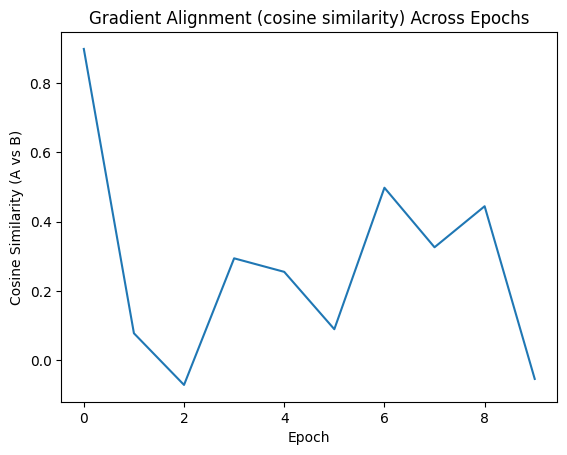

In [ ]:
import matplotlib.pyplot as plt
plt.plot([t.detach().cpu().item() if t.numel() == 1 else t.detach().cpu().mean().item() for t in cos_sims])
plt.title("Gradient Alignment (cosine similarity) Across Epochs for ")
plt.xlabel("Epoch")
plt.ylabel("Cosine Similarity (A vs B)")
plt.show()


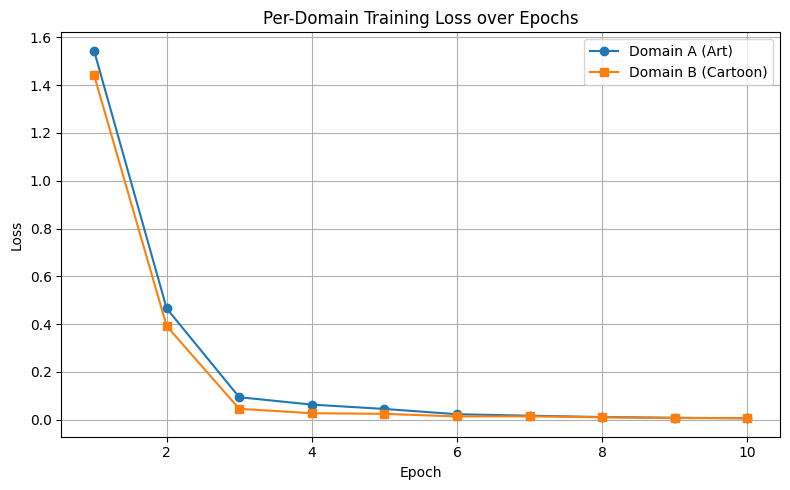

In [ ]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, losses["A_Loss"], label="Domain A (Art)", color='tab:blue', marker='o')
plt.plot(epochs, losses["B_Loss"], label="Domain B (Cartoon)", color='tab:orange', marker='s')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Per-Domain Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
prompt_two_src.eval()

acc_two_src = evaluate_prompt(model, prompt_two_src, target_test_loader, device=device)

print(f"Accuracy of Two Source Model: {acc_two_src*100:.2f}")

Accuracy of Two Source Model: 79.36


# Open-Set and Generalisation Analysis

In [28]:
random.seed(42)
num_classes = len(CLASSES)
k_seen = max(1, int(0.8 * num_classes))  # 80%
all_indices = list(range(num_classes))
random.shuffle(all_indices)
seen_idx = sorted(all_indices[:k_seen])
unseen_idx = sorted(all_indices[k_seen:])

seen_classes = [CLASSES[i] for i in seen_idx]
unseen_classes = [CLASSES[i] for i in unseen_idx]

print("Seen classes:", seen_classes)
print("Unseen classes:", unseen_classes)

Seen classes: ['elephant', 'giraffe', 'guitar', 'horse', 'person']
Unseen classes: ['dog', 'house']


In [29]:
def make_filtered_loader(domain, allowed_classes, batch_size=32, shuffle=False, num_workers=0):
    ds = PACSDataset(DATA_ROOT, domain, transform=preprocess)  # your dataset class
    # map dataset index -> sample (it stores integer label indices per class mapping)
    allowed_idxs = [i for i, (_, lbl) in enumerate(ds.samples) if lbl in [CLASS_TO_IDX[c] for c in allowed_classes]]
    subset = Subset(ds, allowed_idxs)
    return DataLoader(subset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers), subset

# Example: combine domains or use single source domain(s)
source_domains = ['art_painting', 'cartoon', 'photo']
train_loaders = []
for d in source_domains:
    loader, _ = make_filtered_loader(d, seen_classes, batch_size=64, shuffle=True, num_workers=0)
    train_loaders.append(loader)

# For training convenience you can concat datasets into one ConcatDataset if desired
from torch.utils.data import ConcatDataset
train_datasets = []
for d in source_domains:
    _, subset = make_filtered_loader(d, seen_classes, batch_size=64, shuffle=True, num_workers=0)
    train_datasets.append(subset)
train_dataset = ConcatDataset(train_datasets)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)

# Target test loaders:
seen_test_loaders = {}
unseen_test_loaders = {}
for d in ['art_painting', 'cartoon', 'photo', 'sketch']:
    seen_l, _ = make_filtered_loader(d, seen_classes, batch_size=64, shuffle=False, num_workers=0)
    unseen_l, _ = make_filtered_loader(d, unseen_classes, batch_size=64, shuffle=False, num_workers=0)
    seen_test_loaders[d] = seen_l
    unseen_test_loaders[d] = unseen_l

# Optional: global unseen test (all domains)
_, subset_unseen_all = make_filtered_loader('photo', unseen_classes, batch_size=64, shuffle=False, num_workers=0)


Loaded 2048 images from art_painting
Loaded 2344 images from cartoon
Loaded 1670 images from photo
Loaded 2048 images from art_painting
Loaded 2344 images from cartoon
Loaded 1670 images from photo
Loaded 2048 images from art_painting
Loaded 2048 images from art_painting
Loaded 2344 images from cartoon
Loaded 2344 images from cartoon
Loaded 1670 images from photo
Loaded 1670 images from photo
Loaded 3929 images from sketch
Loaded 3929 images from sketch
Loaded 1670 images from photo


In [30]:
prompt_open_set = PromptLearner(model, CLASSES, ctx_len=4, device=device).to(device)
prompt_open_set.context_vectors.requires_grad = True

opt = torch.optim.Adam(prompt_open_set.parameters(), lr=2e-3)

In [31]:
def train_prompt_supervised(model, prompt, loader, opt, device, epochs=10):
    model.eval(); prompt.train()
    for e in range(epochs):
        total_loss = 0.0
        total = correct = 0
        for imgs, labels in tqdm(loader, desc=f"Prompt Train epoch {e+1}/{epochs}"):
            imgs, labels = imgs.to(device), labels.to(device)
            # Map labels to new 0..k_seen-1 space because dataset labels are original mapping
            # Build mapping from original CLASS_TO_IDX to local index among seen classes:
            orig_to_local = {CLASS_TO_IDX[c]: i for i, c in enumerate(seen_classes)}
            local_labels = torch.tensor([orig_to_local[int(l.item())] for l in labels], dtype=torch.long, device=device)

            # forward using prompt -> obtain text_features for seen classes
            text_feats = prompt(selected_class_idx=None)  # returns [k_seen, dim]
            image_feats = model.encode_image(imgs)
            image_feats = image_feats / image_feats.norm(dim=-1, keepdim=True)
            logits = 100.0 * image_feats @ text_feats.T
            loss = F.cross_entropy(logits, local_labels)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == local_labels).sum().item()
            total += local_labels.size(0)
        print(f"Epoch {e+1}: loss={total_loss/len(loader):.4f}, train_acc={correct/total:.4f}")

# Train on concatenated source train_loader
train_prompt_supervised(model, prompt_open_set, train_loader, opt, device, epochs=10)

# Save the learned prompt for later
learned_prompt = prompt_open_set  # retains weights

Prompt Train epoch 1/10: 100%|██████████| 67/67 [00:26<00:00,  2.48it/s]


Epoch 1: loss=1.1787, train_acc=0.5542


Prompt Train epoch 2/10: 100%|██████████| 67/67 [00:26<00:00,  2.48it/s]


Epoch 2: loss=0.2078, train_acc=0.9531


Prompt Train epoch 3/10: 100%|██████████| 67/67 [00:26<00:00,  2.48it/s]


Epoch 3: loss=0.0960, train_acc=0.9712


Prompt Train epoch 4/10: 100%|██████████| 67/67 [00:26<00:00,  2.49it/s]


Epoch 4: loss=0.0651, train_acc=0.9809


Prompt Train epoch 5/10: 100%|██████████| 67/67 [00:26<00:00,  2.48it/s]


Epoch 5: loss=0.0597, train_acc=0.9830


Prompt Train epoch 6/10: 100%|██████████| 67/67 [00:26<00:00,  2.49it/s]


Epoch 6: loss=0.0623, train_acc=0.9823


Prompt Train epoch 7/10: 100%|██████████| 67/67 [00:26<00:00,  2.48it/s]


Epoch 7: loss=0.0527, train_acc=0.9842


Prompt Train epoch 8/10: 100%|██████████| 67/67 [00:26<00:00,  2.49it/s]


Epoch 8: loss=0.0455, train_acc=0.9887


Prompt Train epoch 9/10: 100%|██████████| 67/67 [00:26<00:00,  2.49it/s]


Epoch 9: loss=0.0435, train_acc=0.9880


Prompt Train epoch 10/10: 100%|██████████| 67/67 [00:27<00:00,  2.47it/s]

Epoch 10: loss=0.0463, train_acc=0.9854


In [32]:
@torch.no_grad()
def text_feats_from_template(template, classes):
    tokens = clip.tokenize([template.format(c) for c in classes]).to(device)
    t = model.encode_text(tokens)
    t = t / t.norm(dim=-1, keepdim=True)
    return t

In [33]:
@torch.no_grad()
def evaluate_with_text_feats(model, loader, text_feats, classes_map=None):
    # classes_map: if labels in loader are original indices, need mapping to text_feats rows
    all_preds, all_labels = [], []
    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        image_feats = model.encode_image(imgs)
        image_feats = image_feats / image_feats.norm(dim=-1, keepdim=True)
        logits = 100.0 * image_feats @ text_feats.T
        preds = logits.argmax(dim=1).cpu().numpy()
        # Map original labels to local indices if classes_map provided
        if classes_map is not None:
            labels_np = np.array([classes_map[int(l.item())] for l in labels])
        else:
            labels_np = labels.cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels_np)
    return accuracy_score(all_labels, all_preds)

In [34]:
# Build mapping original -> local index for seen classes
orig_to_local = {CLASS_TO_IDX[c]: i for i, c in enumerate(seen_classes)}
# get text_feats from learned prompt (k_seen x D)
with torch.no_grad():
    text_feats_learned = learned_prompt(selected_class_idx=None)
    text_feats_learned = text_feats_learned / text_feats_learned.norm(dim=-1, keepdim=True)

# Evaluate on seen test loaders across domains
seen_accs = {}
for d, loader in seen_test_loaders.items():
    acc = evaluate_with_text_feats(model, loader, text_feats_learned, classes_map=orig_to_local)
    seen_accs[d] = acc
    print(f"Seen-classes accuracy on {d}: {acc*100:.2f}%")

Seen-classes accuracy on art_painting: 97.67%
Seen-classes accuracy on cartoon: 99.52%
Seen-classes accuracy on photo: 99.92%
Seen-classes accuracy on sketch: 86.29%


In [35]:
template = "a picture of a {}"   # your manual CLIP prompt
text_feats_zero_unseen = text_feats_from_template(template, unseen_classes)  # (k_unseen x D)
# Evaluate zero-shot on unseen loaders (map original label to local 0..k_unseen-1)
orig_to_local_unseen = {CLASS_TO_IDX[c]: i for i, c in enumerate(unseen_classes)}

unseen_accs_zero = {}
for d, loader in unseen_test_loaders.items():
    acc = evaluate_with_text_feats(model, loader, text_feats_zero_unseen, classes_map=orig_to_local_unseen)
    unseen_accs_zero[d] = acc
    print(f"Zero-shot (manual) on unseen classes, domain {d}: {acc*100:.2f}%")

Zero-shot (manual) on unseen classes, domain art_painting: 99.85%
Zero-shot (manual) on unseen classes, domain cartoon: 100.00%
Zero-shot (manual) on unseen classes, domain photo: 100.00%
Zero-shot (manual) on unseen classes, domain sketch: 99.88%


In [36]:
def compute_scores_for_loader(model, loader, text_feats_seen):
    # returns lists of MSPs, cosine_maxes, and is_ood flags
    msp_list, cos_list = [], []
    for imgs, labels in loader:
        imgs = imgs.to(device)
        image_feats = model.encode_image(imgs)
        image_feats = image_feats / image_feats.norm(dim=-1, keepdim=True)
        logits = 100.0 * (image_feats @ text_feats_seen.T)
        probs = F.softmax(logits, dim=1).cpu().detach().numpy()
        msp_list.extend(probs.max(axis=1).tolist())
        # cosine max (since both normalized, dot = cosine)
        cos_vals = (image_feats @ text_feats_seen.T).cpu().numpy()
        cos_list.extend(cos_vals.max(axis=1).tolist())
    return msp_list, cos_list

In [37]:
# Gather in-distribution scores (seen class images)
msp_in, cos_in = [], []
for d, loader in seen_test_loaders.items():
    mi, ci = compute_scores_for_loader(model, loader, text_feats_learned)
    msp_in.extend(mi)
    cos_in.extend(ci)

# Gather out-of-distribution scores (unseen class images)
msp_out, cos_out = [], []
for d, loader in unseen_test_loaders.items():
    mo, co = compute_scores_for_loader(model, loader, text_feats_learned)
    msp_out.extend(mo)
    cos_out.extend(co)

In [38]:
# Build arrays and compute AUROC (label: 1=OOD)
y_true = np.array([0]*len(msp_in) + [1]*len(msp_out))
# For MSP, lower MSP -> more OOD, but roc_auc_score assumes higher score -> positive class,
# so invert MSP by using (1 - MSP) so OOD (1) tends to have higher values
scores_msp = np.array(list(msp_in) + list(msp_out))
scores_msp_inv = 1.0 - scores_msp
scores_cos = np.array(list(cos_in) + list(cos_out)) * -1.0  # smaller (more negative) for OOD? adjust if needed

auroc_msp = roc_auc_score(y_true, scores_msp_inv)
auroc_cos = roc_auc_score(y_true, np.concatenate([cos_in, cos_out]))

In [39]:
def compute_fpr_at_95(y_true, scores):
    # compute false positive rate when true positive rate is 95% for positive class (OOD)
    # We will treat OOD as positive (label 1)
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(y_true, scores)
    # find threshold where tpr >= 0.95, take corresponding fpr
    idx = np.where(tpr >= 0.95)[0]
    if len(idx) == 0:
        return 1.0
    return float(fpr[idx[0]])

In [40]:
fpr95_msp = compute_fpr_at_95(y_true, scores_msp_inv)
fpr95_cos = compute_fpr_at_95(y_true, np.concatenate([cos_in, cos_out]))

print("\n--- OOD detection metrics (learned prompt as seen classes) ---")
print(f"AUROC (MSP-inv): {auroc_msp:.4f}, FPR95 (MSP-inv): {fpr95_msp:.4f}")
print(f"AUROC (cosine): {auroc_cos:.4f}, FPR95 (cosine): {fpr95_cos:.4f}")


--- OOD detection metrics (learned prompt as seen classes) ---
AUROC (MSP-inv): 0.8911, FPR95 (MSP-inv): 0.3045
AUROC (cosine): 0.1867, FPR95 (cosine): 0.9772


In [41]:
with torch.no_grad():
    text_feats_manual_seen = text_feats_from_template("a picture of a {}", seen_classes)
    # compute pairwise cosine between learned prompt tokens and manual text features
    # both are normalized
    sims = (text_feats_learned @ text_feats_manual_seen.T).cpu().numpy()  # k_seen x k_seen
    # you can examine diagonal means (self-similarity)
    diag_mean = np.mean(np.diag(sims))
    print(f"Mean diag cosine (learned vs manual for same class): {diag_mean:.4f}")
    print("Pairwise similarity matrix (learned_prompt vs manual):\n", sims)


Mean diag cosine (learned vs manual for same class): 0.3552
Pairwise similarity matrix (learned_prompt vs manual):
 [[ 0.35880044  0.27784026  0.22973306  0.27852273  0.2516501 ]
 [ 0.14886841  0.29126972  0.18977728  0.176034    0.10285819]
 [ 0.20633107  0.31883374  0.34692097  0.26078734  0.2186355 ]
 [ 0.14544879  0.17231248  0.17823853  0.24219626  0.13167013]
 [ 0.4492799   0.46680883  0.48428395  0.49640635  0.5366131 ]
 [-0.02774831  0.03524073  0.05833695  0.0198058  -0.01402805]
 [ 0.01450916  0.06785354  0.06170031  0.05244846  0.01423706]]


In [42]:
print("\n=== Summary ===")
print("Seen-class accuracies by domain (learned prompt):")
for d, a in seen_accs.items():
    print(f"  {d}: {a*100:.2f}%")
print("\nUnseen accuracies (zero-shot manual):")
for d, a in unseen_accs_zero.items():
    print(f"  {d}: {a*100:.2f}%")
print(f"\nAUROC MSP-inv: {auroc_msp:.4f}, FPR95 MSP-inv: {fpr95_msp:.4f}")
print(f"AUROC cosine: {auroc_cos:.4f}, FPR95 cosine: {fpr95_cos:.4f}")


=== Summary ===
Seen-class accuracies by domain (learned prompt):
  art_painting: 97.67%
  cartoon: 99.52%
  photo: 99.92%
  sketch: 86.29%

Unseen accuracies (zero-shot manual):
  art_painting: 99.85%
  cartoon: 100.00%
  photo: 100.00%
  sketch: 99.88%

AUROC MSP-inv: 0.8911, FPR95 MSP-inv: 0.3045
AUROC cosine: 0.1867, FPR95 cosine: 0.9772


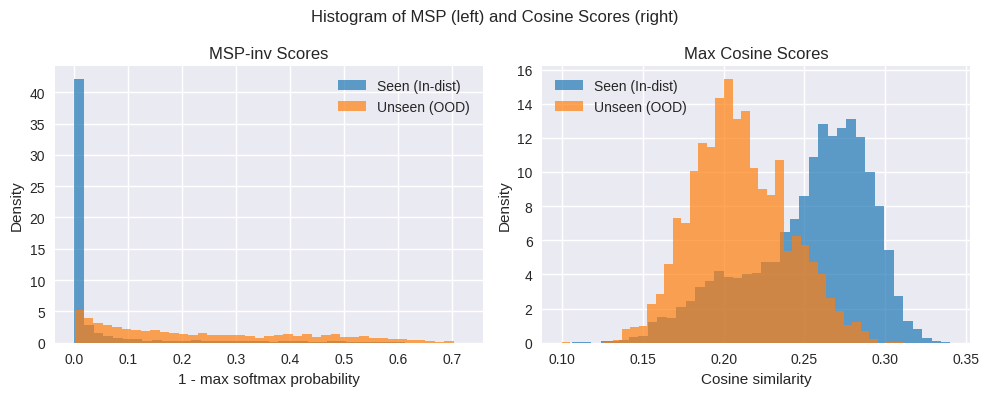

In [44]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("seaborn-v0_8")

fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

# MSP (1 - MSP for OOD)
axes[0].hist(1 - np.array(msp_in), bins=40, alpha=0.7, label="Seen (In-dist)", color="tab:blue", density=True)
axes[0].hist(1 - np.array(msp_out), bins=40, alpha=0.7, label="Unseen (OOD)", color="tab:orange", density=True)
axes[0].set_title("MSP-inv Scores")
axes[0].set_xlabel("1 - max softmax probability")
axes[0].set_ylabel("Density")
axes[0].legend()

# Cosine similarity
axes[1].hist(cos_in, bins=40, alpha=0.7, label="Seen (In-dist)", color="tab:blue", density=True)
axes[1].hist(cos_out, bins=40, alpha=0.7, label="Unseen (OOD)", color="tab:orange", density=True)
axes[1].set_title("Max Cosine Scores")
axes[1].set_xlabel("Cosine similarity")
axes[1].set_ylabel("Density")
axes[1].legend()

plt.suptitle("Histogram of MSP (left) and Cosine Scores (right)", fontsize=12)
plt.show()


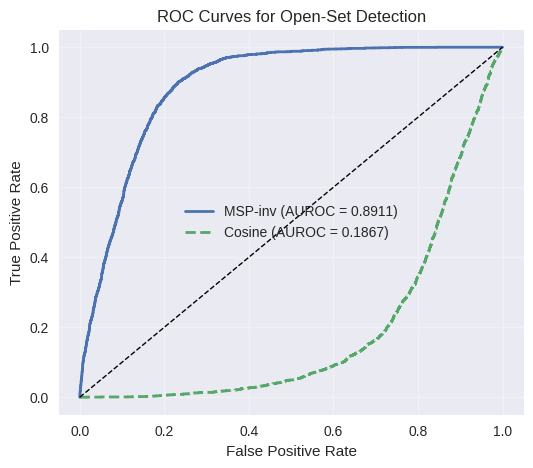

In [45]:
from sklearn.metrics import roc_curve, auc

y_true = np.array([0]*len(msp_in) + [1]*len(msp_out))
msp_scores_inv = 1 - np.concatenate([msp_in, msp_out])
cos_scores = np.concatenate([cos_in, cos_out])

fpr_msp, tpr_msp, _ = roc_curve(y_true, msp_scores_inv)
fpr_cos, tpr_cos, _ = roc_curve(y_true, cos_scores)
auroc_msp = auc(fpr_msp, tpr_msp)
auroc_cos = auc(fpr_cos, tpr_cos)

plt.figure(figsize=(6, 5))
plt.plot(fpr_msp, tpr_msp, label=f"MSP-inv (AUROC = {auroc_msp:.4f})", linewidth=2)
plt.plot(fpr_cos, tpr_cos, linestyle="--", label=f"Cosine (AUROC = {auroc_cos:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Open-Set Detection")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


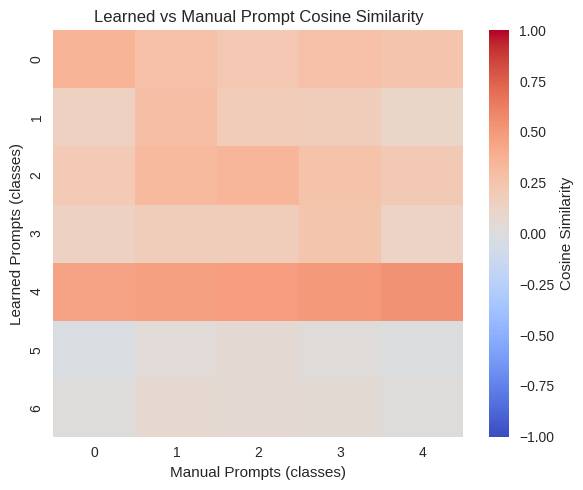

In [46]:
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(
    sims,
    cmap="coolwarm",
    annot=False,
    cbar_kws={"label": "Cosine Similarity"},
    vmin=-1, vmax=1
)
plt.title("Learned vs Manual Prompt Cosine Similarity")
plt.xlabel("Manual Prompts (classes)")
plt.ylabel("Learned Prompts (classes)")
plt.tight_layout()
plt.show()


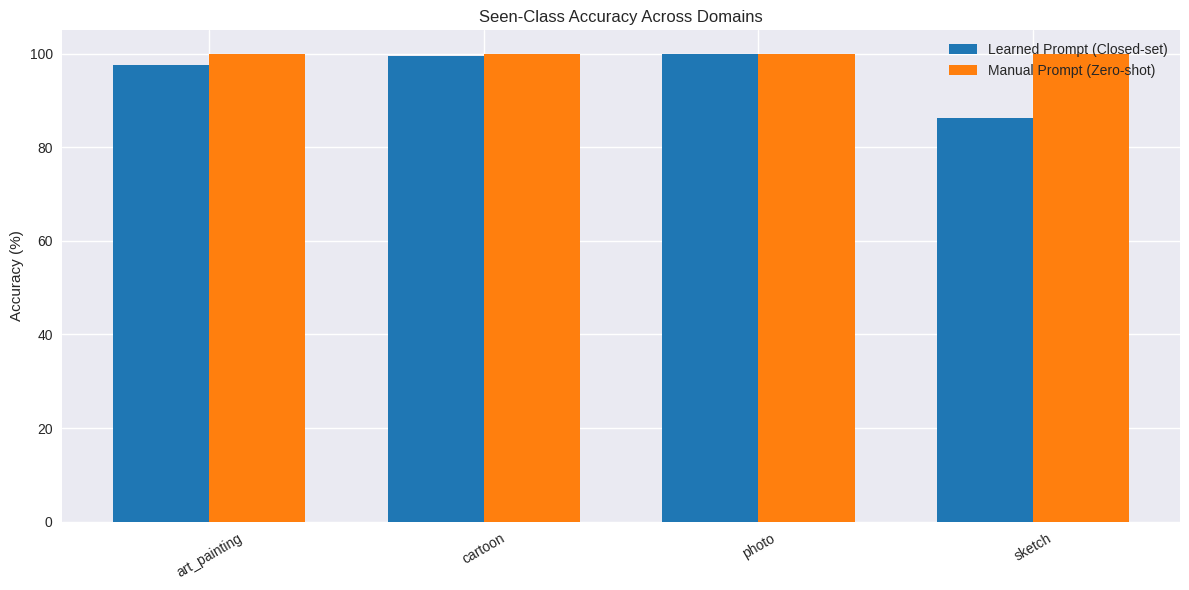

In [55]:
domains = list(seen_accs.keys())
acc_learned = [seen_accs[d] * 100 for d in domains]  # learned prompt
acc_manual = [unseen_accs_zero.get(d, 0) * 100 for d in domains]  # manual prompt baseline

x = np.arange(len(domains))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, acc_learned, width, label="Learned Prompt (Closed-set)", color="tab:blue")
ax.bar(x + width/2, acc_manual, width, label="Manual Prompt (Zero-shot)", color="tab:orange")
ax.set_xticks(x)
ax.set_xticklabels(domains, rotation=30)
ax.set_ylabel("Accuracy (%)")
ax.set_title("Seen-Class Accuracy Across Domains")
ax.legend()
plt.tight_layout()
plt.show()
